显示点扩展函数

显示点目标

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
rect_patch = np.load("rect_patchs.npy")

num, h,w = rect_patch.shape
vis = list()
for i in range(num):
    sample = torch.tensor(rect_patch[i,:,:]).float()
    vis.append(sample.view(1,h,w))

img_grid = torchvision.utils.make_grid(vis,padding = num,pad_value = 1,nrow= 5)
plt.rcParams['figure.figsize'] = (20.0, 16.0) 
plt.imshow(img_grid.permute(1,2,0))
plt.axis("off")
plt.show()

显示光谱压缩图像

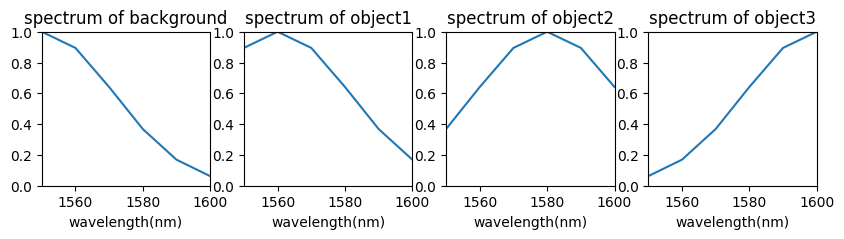

In [214]:

import matplotlib.pyplot as plt
import random

def gen_weight_and_label(wave_count, labels, weight_mode="onehot", have_noise = True):
    # labels ：取值（0-9） 点的标签类别，len(labels): 二分类，五分类，十分类
    # wave_count: 点光源包含的波长数量， 和PSF0406_02_256by256.npy文件中的波长对应。
    # weight_mode : 点的叠加分布，onehot型(onehot)，twohot型(twohot)，高斯型(gauss)，指数型(exp)
    label = random.choice(labels)
    weight =  np.zeros(wave_count)

    if weight_mode == "onehot":
        weight[label] = 1.0
    elif weight_mode == "twohot":
        if label >= wave_count - 1:
            assert(0)
        weight[label] = 0.5  # 权重比例可调
        weight[label+1] = 0.5

    elif weight_mode == "twohot_far":
        if label >= wave_count - 5:
            assert(0)
        weight[label] = 0.5
        weight[label+5] = 0.5

    elif weight_mode == "gauss":
        x = np.linspace(0, wave_count - 1, wave_count)
        weight = np.exp(-1 * (x - label)**2 / ((wave_count/2)**2 ))
        # logging.debug("label:{}, weight:{}\n".format(label, weight))
    elif weight_mode == "exp":
        assert(0)
    else:
        assert(0)

    if have_noise:
        noise = np.random.uniform(low = 0., high = 0.3 , size = (wave_count) )  
        weight = weight + noise
        # print(weight)
    return weight, label

wave_count = 6
labels = [0,1,3,5]
leg = {0:"spectrum of background", 1:"spectrum of object1",  3:"spectrum of object2",  5:"spectrum of object3"}
x = [1550,1560,1570,1580,1590,1600]
fig, ax = plt.subplots(1,4)
for i in range(4):
    weight0 , label0 = gen_weight_and_label(wave_count, labels = [labels[i]], weight_mode="gauss", have_noise = False)
    ax[i].plot(x,weight0)    
    ax[i].set_title(leg[labels[i]])
    ax[i].set_xlabel("wavelength(nm)")
    ax[i].set_xlim((1550,1600))
    ax[i].set_ylim((0,1))
plt.rcParams['figure.figsize'] = (12.0, 2.0) 
plt.xlim((1550,1600))
plt.show()

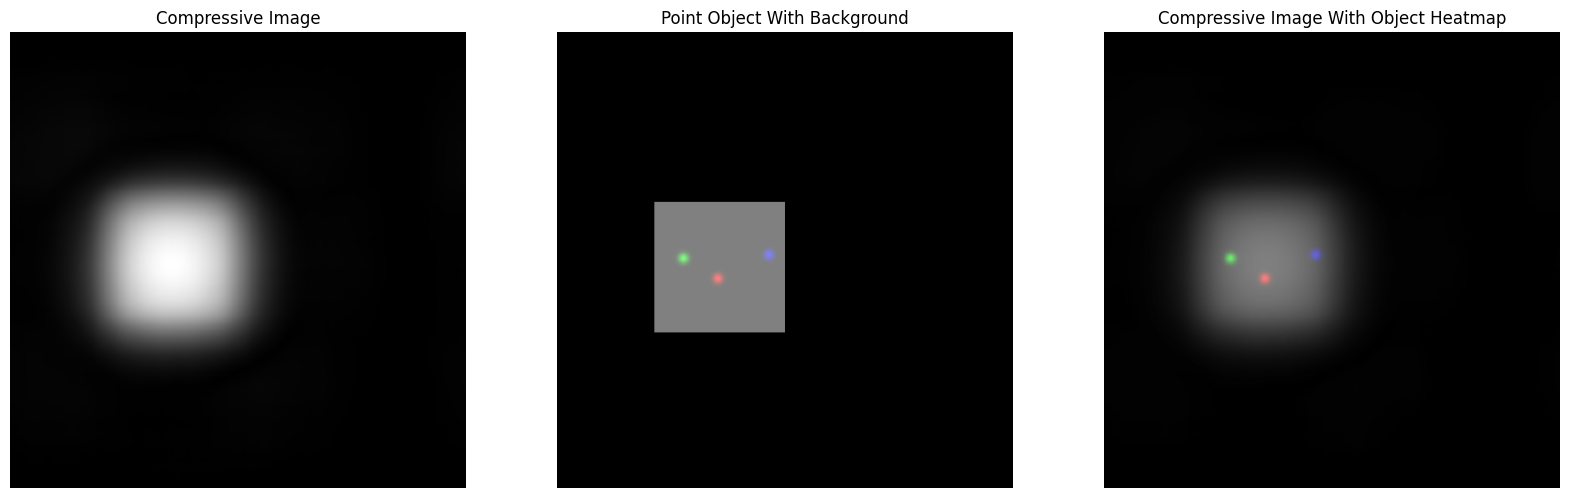

In [216]:
import json
import matplotlib.pyplot as plt
import numpy as np
import cv2
from lib.utils.image import draw_umich_gaussian, draw_msra_gaussian

def add_circle(img, anns, radius = 3 , c = (255,0,0)): 
    for ann in anns:
        px = int(ann[1])
        py = int(ann[2])
        cls = int(ann[0])
        cv2.circle(img,(px,py), radius, c, -1)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, str(cls), (px + 5 , py - 5), font, 0.5 , c,  thickness=1, lineType=cv2.LINE_AA)
    return img

def gen_background(heatmap, anns, width = 111):
    h,w=heatmap.shape
    mask = np.zeros((h,w,3))
    rectx = anns[0][5]
    recty = anns[0][6]

    x1 = rectx - width//2
    x2 = rectx + width//2
    y1 = recty - width//2
    y2 = recty + width//2
    mask[y1:y2, x1:x2, :] = 1
    return np.ascontiguousarray(mask * 255 , dtype=np.uint8)


def add_gt_mask(heatmap, anns, radius=3, factor= 1.0): 
    h,w=heatmap.shape
    mask = np.zeros((h,w,3))
    for ann in anns:
        px = int(ann[1])
        py = int(ann[2])
        cls = int(ann[0])

        if cls == 5:
            mask[:,:,0] = draw_msra_gaussian(mask[:,:,0],(px,py), radius)
        if cls == 3:
            mask[:,:,1] = draw_msra_gaussian(mask[:,:,1],(px,py), radius)
        if cls == 1:
            mask[:,:,2] = draw_msra_gaussian(mask[:,:,2],(px,py), radius)
    return np.ascontiguousarray(mask * 255 * factor, dtype=np.uint8)

for idx in range(17,18):
    img = np.load("../data/PSF0620_04_4_40/sample_{:05d}.npy".format(idx))
    with open("../data/PSF0620_04_4_40/sample_{:05d}.json".format(idx), "r") as fp:
        gts = json.load(fp)
    c,h,w=img.shape
    
    # Heatmap
    heatmap = np.zeros((h,w))
    backgroud = gen_background(heatmap, gts)

    points_mask = add_gt_mask(heatmap, gts, radius=3)

    # image
    img = np.concatenate((img,img,img), axis=0)
    img = img.transpose(1,2,0)*255
    img = np.ascontiguousarray(img, dtype=np.uint8)

    # object 
    obj = cv2.addWeighted(backgroud, 0.5, points_mask, 0.5, 0)

    # image + heatmap
    merge = cv2.addWeighted(img, 0.5, points_mask, 0.5, 0)

    # plot
    fig, ax = plt.subplots(1,3)    
    ax[0].imshow(img)
    ax[0].axis("off")
    ax[0].set_title("Compressive Image")
    ax[1].imshow(obj)
    ax[1].axis("off")
    ax[1].set_title("Point Object With Background")
    ax[2].imshow(merge)
    ax[2].axis("off")
    ax[2].set_title("Compressive Image With Object Heatmap")
    # cv2.imwrite("img.png",img)
    # cv2.imwrite("object.png",obj)
    # cv2.imwrite("heatmap.png",points_mask)
plt.rcParams['figure.figsize'] = (20.0, 16.0) 
plt.show()
